In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [2]:
df = pd.read_csv('UpdatedWeights.csv')
# df = pd.read_csv('Dynamic Model Weights.csv')
# df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
# df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
# df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Momentum,Theme Momentum,Volatility,Theme Volatility,Growth,Quality,Value
0,2006-06-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2006-06-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2006-06-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2006-06-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2006-06-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
4640,2025-04-09,0.137498,0.171848,0.174827,0.177012,0.000000,0.161869,0.176946
4641,2025-04-11,0.119539,0.141658,0.164221,0.165664,0.119385,0.133945,0.155587
4642,2025-04-15,0.000000,0.187683,0.218240,0.220466,0.000000,0.193931,0.179680
4643,2025-04-16,0.000000,0.238823,0.262854,0.271530,0.000000,0.226793,0.000000


In [63]:
from scipy.stats import skew, kurtosis, zscore

# Function to compute factor statistics
def compute_factor_statistics(df, factors, window_size=20, z_threshold=2):
    """
    Computes rolling volatility, skewness, kurtosis, cross-factor dispersion, and Z-scores.
    
    Parameters:
    df (DataFrame): Input data with Date and factor columns.
    factors (list): List of factor column names.
    window_size (int): Rolling window size.
    z_threshold (float): Threshold for extreme Z-score detection.

    Returns:
    DataFrame: Processed data with additional computed columns.
    """
    df = df.copy()
    
    # Compute Rolling Standard Deviation (Volatility)
    for col in factors:
        df[f"{col}_Rolling_Std"] = df[col].rolling(window=window_size).std()

    # Compute Rolling Skewness?
    for col in factors:
        df[f"{col}_Rolling_Skew"] = df[col].rolling(window=window_size).apply(skew, raw=True)

    # Compute Rolling Kurtosis
    for col in factors:
        df[f"{col}_Rolling_Kurtosis"] = df[col].rolling(window=window_size).apply(kurtosis, raw=True)

    # Compute Cross-Factor Dispersion (Standard Deviation across factors at each time step)
    df["Cross_Factor_Dispersion"] = df[factors].std(axis=1)

    # Compute Z-Scores for each factor (Identifying extreme movements)
    for col in factors:
        df[f"{col}_Z_Score"] = zscore(df[col].fillna(0))  # Normalize by mean and std

    # Identify extreme Z-score instances (> threshold)
    df["Extreme_Movement_Flag"] = (df[[f"{col}_Z_Score" for col in factors]].abs() > z_threshold).any(axis=1)

    return df

# Example Usage:
# Assuming df is already loaded with a "Date" column and factor columns
factors = ["Momentum", "Theme Momentum", "Volatility", "Theme Volatility", "Growth", "Quality", "Value"]
# factors = ["AM", "Quality", "Vol", "Growth", "Value"]

# Compute all statistics
df_processed = compute_factor_statistics(df, factors)

# Display last few rows
df_processed.tail()

,Date,Momentum,Theme Momentum,Volatility,Theme Volatility,Growth,Quality,Value,Momentum_Rolling_Std,Theme Momentum_Rolling_Std,...,Value_Rolling_Kurtosis,Cross_Factor_Dispersion,Momentum_Z_Score,Theme Momentum_Z_Score,Volatility_Z_Score,Theme Volatility_Z_Score,Growth_Z_Score,Quality_Z_Score,Value_Z_Score,Extreme_Movement_Flag
4640,2025-04-09,0.137498,0.171848,0.174827,0.177012,0.000000,0.161869,0.176946,0.050636,0.121960,...,1.578161,0.064536,0.160019,0.267155,0.398697,0.075759,-0.849182,0.502238,0.615623,False
4641,2025-04-11,0.119539,0.141658,0.164221,0.165664,0.119385,0.133945,0.155587,0.054937,0.122969,...,2.070482,0.019639,0.014688,0.061669,0.312337,0.006335,0.462805,0.268887,0.443890,False
4642,2025-04-15,0.000000,0.187683,0.218240,0.220466,0.000000,0.193931,0.179680,0.054937,0.125462,...,2.540574,0.098739,-0.952662,0.374937,0.752216,0.341595,-0.849182,0.770178,0.637606,False
4643,2025-04-16,0.000000,0.238823,0.262854,0.271530,0.000000,0.226793,0.000000,0.054937,0.130015,...,5.283460,0.134434,-0.952662,0.723019,1.115507,0.653994,-0.849182,1.044798,-0.807096,False
4644,2025-04-17,0.000000,0.288028,0.309258,0.402713,0.000000,0.000000,0.000000,0.054937,0.136577,...,5.283460,0.181623,-0.952662,1.057930,1.493385,1.456539,-0.849182,-0.850472,-0.807096,False


In [50]:
# # Adjusted function with stricter conditions
# def refined_rebalance_triggers(df, factors, vol_threshold=2, z_threshold=2.5, dispersion_threshold=2):
#     df = df.copy()

#     # Compute mean and std of rolling volatility for normalization
#     avg_vol = df[[f"{col}_Rolling_Std" for col in factors]].mean().mean()
#     std_vol = df[[f"{col}_Rolling_Std" for col in factors]].std().mean()

#     # Volatility Breakout
#     df["Volatility_Breakout"] = (df[[f"{col}_Rolling_Std" for col in factors]].max(axis=1) > avg_vol + vol_threshold * std_vol)

#     # Extreme Factor Move (Stronger Threshold)
#     df["Extreme_Factor_Move"] = (df[[f"{col}_Z_Score" for col in factors]].abs() > z_threshold).sum(axis=1) >= 2  # At least 2 factors

#     # Cross-Factor Dispersion Breakout
#     avg_disp = df["Cross_Factor_Dispersion"].mean()
#     std_disp = df["Cross_Factor_Dispersion"].std()
#     df["Dispersion_Breakout"] = df["Cross_Factor_Dispersion"] > avg_disp + dispersion_threshold * std_disp

#     # Require at least 2 conditions to trigger
#     df["Rebalance_Trigger"] = (df[["Volatility_Breakout", "Extreme_Factor_Move", "Dispersion_Breakout"]].sum(axis=1) >= 2)

#     # Remove consecutive signals (5-day gap required)
#     df["Rebalance_Trigger"] = df["Rebalance_Trigger"] & ~df["Rebalance_Trigger"].shift(1).fillna(False) & ~df["Rebalance_Trigger"].shift(2).fillna(False)

#     return df

# # Apply refined trigger function
# df_triggers = refined_rebalance_triggers(df_processed, factors)

# # Get final rebalance dates
# real_rebalance_dates = df_triggers[df_triggers["Rebalance_Trigger"]]["Date"]
# print(real_rebalance_dates)

In [51]:
# def refined_rebalance_triggers(df, factors, vol_threshold=2, z_threshold=2.5, dispersion_threshold=2, cooldown_days=9):
#     df = df.copy()

#     # Compute mean and std of rolling volatility for normalization
#     avg_vol = df[[f"{col}_Rolling_Std" for col in factors]].mean().mean()
#     std_vol = df[[f"{col}_Rolling_Std" for col in factors]].std().mean()

#     # Volatility Breakout
#     df["Volatility_Breakout"] = (df[[f"{col}_Rolling_Std" for col in factors]].max(axis=1) > avg_vol + vol_threshold * std_vol)

#     # Extreme Factor Move (Stronger Threshold)
#     df["Extreme_Factor_Move"] = (df[[f"{col}_Z_Score" for col in factors]].abs() > z_threshold).sum(axis=1) >= 2  # At least 2 factors

#     # Cross-Factor Dispersion Breakout
#     avg_disp = df["Cross_Factor_Dispersion"].mean()
#     std_disp = df["Cross_Factor_Dispersion"].std()
#     df["Dispersion_Breakout"] = df["Cross_Factor_Dispersion"] > avg_disp + dispersion_threshold * std_disp

#     # Require at least 2 conditions to trigger
#     df["Rebalance_Trigger"] = (df[["Volatility_Breakout", "Extreme_Factor_Move", "Dispersion_Breakout"]].sum(axis=1) >= 2)

#     # Extract actual date values instead of indices
#     rebalance_dates = df.loc[df["Rebalance_Trigger"], "Date"].tolist()

#     # Filter out dates that are too close (7-day gap required)
#     filtered_dates = []
    
#     for date in rebalance_dates:
#         if not filtered_dates or (date - filtered_dates[-1]).days >= cooldown_days:
#             filtered_dates.append(date)
    
#     # Set final rebalance trigger column
#     df["Rebalance_Trigger"] = df["Date"].isin(filtered_dates)

#     return df

# # Apply refined trigger function with 7-day cooldown
# df_triggers = refined_rebalance_triggers(df_processed, factors, cooldown_days=7)

# # Get final rebalance dates
# real_rebalance_dates = df_triggers[df_triggers["Rebalance_Trigger"]]["Date"]
# print(real_rebalance_dates)

In [64]:
df_processed[df_processed['Extreme_Movement_Flag'] == True]
# or simply

,Date,Momentum,Theme Momentum,Volatility,Theme Volatility,Growth,Quality,Value,Momentum_Rolling_Std,Theme Momentum_Rolling_Std,...,Value_Rolling_Kurtosis,Cross_Factor_Dispersion,Momentum_Z_Score,Theme Momentum_Z_Score,Volatility_Z_Score,Theme Volatility_Z_Score,Growth_Z_Score,Quality_Z_Score,Value_Z_Score,Extreme_Movement_Flag
44,2006-08-23,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,0.377964,-0.952662,-0.902521,-1.024930,5.110584,-0.849182,-0.850472,-0.807096,True
45,2006-08-24,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,0.377964,-0.952662,-0.902521,-1.024930,5.110584,-0.849182,-0.850472,-0.807096,True
46,2006-08-25,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,0.377964,-0.952662,-0.902521,-1.024930,5.110584,-0.849182,-0.850472,-0.807096,True
47,2006-08-28,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,0.377964,-0.952662,-0.902521,-1.024930,5.110584,-0.849182,-0.850472,-0.807096,True
48,2006-08-29,0.0,0.000000,0.000000,0.602213,0.0,0.000000,0.397787,0.000000,0.000000,...,15.052632,0.251011,-0.952662,-0.902521,-1.024930,2.677026,-0.849182,-0.850472,2.391284,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528,2024-10-25,0.0,0.000000,0.305788,0.341041,0.0,0.353170,0.000000,0.000000,0.000000,...,NaN,0.178740,-0.952662,-0.902521,1.465128,1.079246,-0.849182,2.100911,-0.807096,True
4582,2025-01-14,0.0,0.516842,0.000000,0.000000,0.0,0.483158,0.000000,0.055695,0.080153,...,-1.240697,0.244169,-0.952662,2.615336,-1.024930,-1.007156,-0.849182,3.187199,-0.807096,True
4624,2025-03-17,0.0,0.000000,0.502190,0.497810,0.0,0.000000,0.000000,0.033528,0.069755,...,1.842247,0.243978,-0.952662,-0.902521,3.064446,2.038313,-0.849182,-0.850472,-0.807096,True
4636,2025-04-03,0.0,0.493398,0.000000,0.000000,0.0,0.000000,0.506602,0.000000,0.116043,...,0.398315,0.244005,-0.952662,2.455768,-1.024930,-1.007156,-0.849182,-0.850472,3.266205,True


In [65]:
def refined_rebalance_triggers(df, factors, vol_threshold=2, z_threshold=2.5, dispersion_threshold=2, cooldown_days=9):
# def refined_rebalance_triggers(df, factors, vol_threshold=2, z_threshold=1.5, dispersion_threshold=2, cooldown_days=9):

    df = df.copy()

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Compute mean and std of rolling volatility for normalization
    avg_vol = df[[f"{col}_Rolling_Std" for col in factors]].mean().mean()
    std_vol = df[[f"{col}_Rolling_Std" for col in factors]].std().mean()

    # Volatility Breakout
    df["Volatility_Breakout"] = (df[[f"{col}_Rolling_Std" for col in factors]].max(axis=1) > avg_vol + vol_threshold * std_vol)

    # Extreme Factor Move (Stronger Threshold)
    df["Extreme_Factor_Move"] = (df[[f"{col}_Z_Score" for col in factors]].abs() > z_threshold).sum(axis=1) >= 2

    # Cross-Factor Dispersion Breakout
    avg_disp = df["Cross_Factor_Dispersion"].mean()
    std_disp = df["Cross_Factor_Dispersion"].std()
    df["Dispersion_Breakout"] = df["Cross_Factor_Dispersion"] > avg_disp + dispersion_threshold * std_disp

    # Require at least 2 conditions to trigger
    df["Rebalance_Trigger"] = (df[["Volatility_Breakout", "Extreme_Factor_Move", "Dispersion_Breakout"]].sum(axis=1) >= 2)

    # Extract actual date values instead of indices
    rebalance_dates = df.loc[df["Rebalance_Trigger"], "Date"].tolist()

    # Filter out dates that are too close (cooldown period)
    filtered_dates = []
    for date in rebalance_dates:
        if not filtered_dates or (date - filtered_dates[-1]).days >= cooldown_days:
            filtered_dates.append(date)

    # Set final rebalance trigger column
    df["Rebalance_Trigger"] = df["Date"].isin(filtered_dates)

    return df

# Apply refined trigger function with 7-day cooldown
df_triggers = refined_rebalance_triggers(df_processed, factors, cooldown_days=9)

# Get final rebalance dates
real_rebalance_dates = df_triggers[df_triggers["Rebalance_Trigger"]]["Date"]
print(real_rebalance_dates)

44     2006-08-23
115    2006-12-05
129    2006-12-26
179    2007-03-12
198    2007-04-10
          ...    
4332   2024-01-08
4376   2024-03-13
4383   2024-03-22
4407   2024-05-02
4522   2024-10-17
Name: Date, Length: 102, dtype: datetime64[ns]


In [66]:
real_rebalance_dates.to_csv('TriggerRebalDates12DCooldown.csv')

In [67]:
real_rebalance_dates

44     2006-08-23
115    2006-12-05
129    2006-12-26
179    2007-03-12
198    2007-04-10
          ...    
4332   2024-01-08
4376   2024-03-13
4383   2024-03-22
4407   2024-05-02
4522   2024-10-17
Name: Date, Length: 102, dtype: datetime64[ns]

In [68]:
# Ensure 'Date' in df is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set index to Date for easier handling
df = df.set_index('Date')

# Create an empty DataFrame to store filled weights
filled_weights = pd.DataFrame(index=df.index, columns=df.columns)

# Your list of rebalance dates (as a pandas Series)
real_rebalance_dates = real_rebalance_dates.sort_values().reset_index(drop=True)

# Loop through each rebalance date and fill weights till next
for i in range(len(real_rebalance_dates) - 1):
    start = real_rebalance_dates[i]
    end = real_rebalance_dates[i + 1]
    if start in df.index:
        filled_weights.loc[start:end] = df.loc[start].values

# Forward-fill the last rebalance date's weights to the end
last_date = real_rebalance_dates.iloc[-1]
if last_date in df.index:
    filled_weights.loc[last_date:] = df.loc[last_date].values

# Reset index if you need the Date column back
filled_weights = filled_weights.reset_index()
# Make sure Date column is datetime
filled_weights['Date'] = pd.to_datetime(filled_weights['Date'])

# Set Date as index
filled_weights = filled_weights.set_index('Date')

# Get last date and calculate the 5 years before
end_year = filled_weights.index.max().year
years = list(range(end_year, end_year - 5, -1))  # Last 5 years

# Now load the benchmark data
df1 = pd.read_excel('latest size data.xlsx')
df1 = df1[['Date', 'NIFTY500']]
df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1['Date'] = pd.to_datetime(df1['Date'])
filled_weights = pd.merge(filled_weights,df1 , on='Date')
filled_weights =  filled_weights.dropna()
filled_weights

# Plotting
for year in years:
    yearly_data = filled_weights[filled_weights.index.year == year]
    
    if yearly_data.empty:
        continue  # Skip if no data

    ax = yearly_data.plot.area(figsize=(12, 6), stacked=True, cmap='tab20')
    ax.set_title(f"Portfolio Weights - {year}")
    ax.set_ylabel("Weight")
    ax.set_xlabel("Date")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()

AttributeError: 'Index' object has no attribute 'year'

AttributeError: 'Series' object has no attribute 'year'

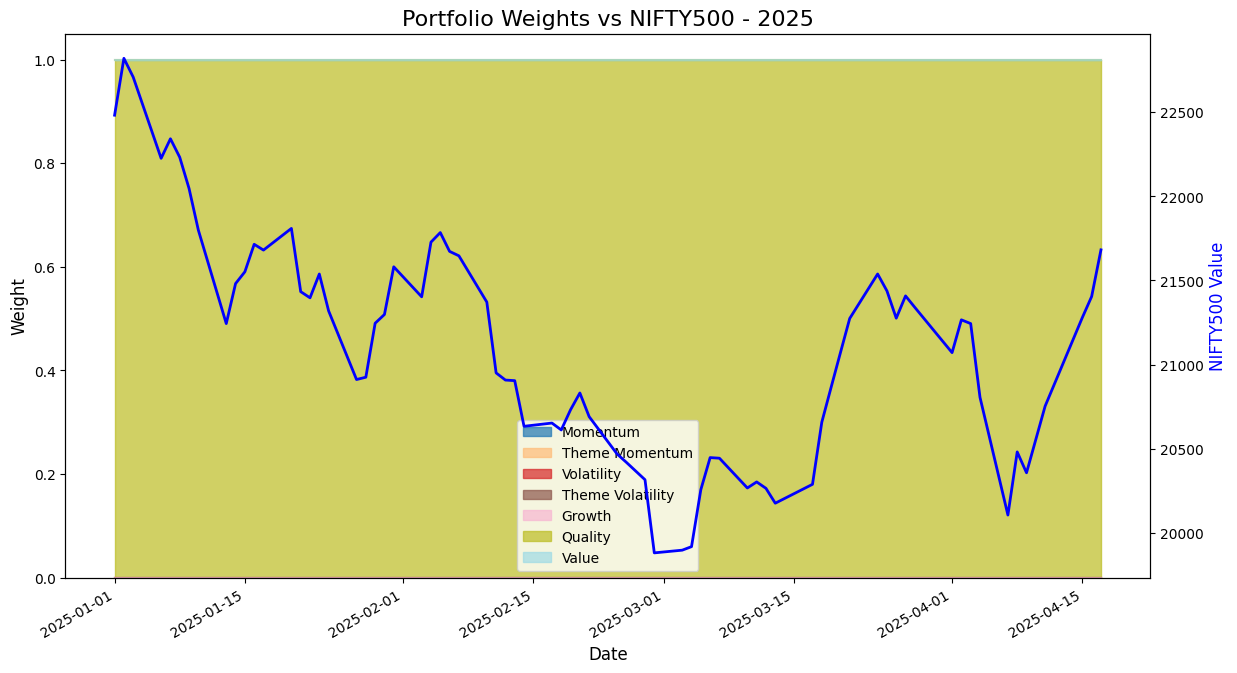

In [69]:
# # Ensure 'Date' in df is datetime
# df['Date'] = pd.to_datetime(df['Date'])

# # Set index to Date for easier handling
# df = df.set_index('Date')

# Create an empty DataFrame to store filled weights
filled_weights = pd.DataFrame(index=df.index, columns=df.columns)

# Your list of rebalance dates (as a pandas Series)
real_rebalance_dates = real_rebalance_dates.sort_values().reset_index(drop=True)

# Loop through each rebalance date and fill weights till next
for i in range(len(real_rebalance_dates) - 1):
    start = real_rebalance_dates[i]
    end = real_rebalance_dates[i + 1]
    if start in df.index:
        filled_weights.loc[start:end] = df.loc[start].values

# Forward-fill the last rebalance date's weights to the end
last_date = real_rebalance_dates.iloc[-1]
if last_date in df.index:
    filled_weights.loc[last_date:] = df.loc[last_date].values

# Reset index if you need the Date column back
filled_weights = filled_weights.reset_index()
# Make sure Date column is datetime
filled_weights['Date'] = pd.to_datetime(filled_weights['Date'])

# Now load the benchmark data
df1 = pd.read_excel('latest size data.xlsx')
df1 = df1[['Date', 'NIFTY500']]
df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1['Date'] = pd.to_datetime(df1['Date'])

# Merge and set Date as index
filled_weights = pd.merge(filled_weights, df1, on='Date')
filled_weights = filled_weights.dropna()
filled_weights = filled_weights.set_index('Date')

# Separate NIFTY500 from weights
nifty_data = filled_weights['NIFTY500'].copy()
weight_columns = [col for col in filled_weights.columns if col != 'NIFTY500']
weights_only = filled_weights[weight_columns]

# Get last date and calculate the 5 years before
end_year = filled_weights.index.year.max()
years = list(range(end_year, end_year - 5, -1))  # Last 5 years

# Convert rebalance_dates to datetime if it's not already
real_rebalance_dates = pd.to_datetime(real_rebalance_dates)

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

for year in years:
    yearly_data = weights_only[weights_only.index.year == year]
    yearly_nifty = nifty_data[nifty_data.index.year == year]
    
    if yearly_data.empty:
        continue  # Skip if no data

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot stacked area chart for weights
    yearly_data.plot.area(ax=ax1, stacked=True, cmap='tab20', alpha=0.7)
    ax1.set_title(f"Portfolio Weights vs NIFTY500 - {year}", fontsize=16)
    ax1.set_ylabel("Weight", fontsize=12)
    ax1.set_xlabel("Date", fontsize=12)
    
    # Create second y-axis for NIFTY500
    ax2 = ax1.twinx()
    ax2.plot(yearly_nifty.index, yearly_nifty.values, 'b-', linewidth=2, label='NIFTY500')
    ax2.set_ylabel('NIFTY500 Value', color='b', fontsize=12)
    
    # Add rebalance dates as red dots
    year_rebal_dates = real_rebalance_dates[real_rebalance_dates.year == year]
    for rebal_date in year_rebal_dates:
        if rebal_date in yearly_nifty.index:
            nifty_val = yearly_nifty.loc[rebal_date]
            ax2.plot(rebal_date, nifty_val, 'ro', markersize=8, label='_nolegend_')
    
    # Add red dot to legend manually
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', marker='o', linestyle='None', markersize=8)]
    ax2.legend(custom_lines, ['Rebalance Dates'], loc='upper right')
    
    # Adjust primary axis legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Portfolio Components")
    
    plt.tight_layout()
    plt.show()

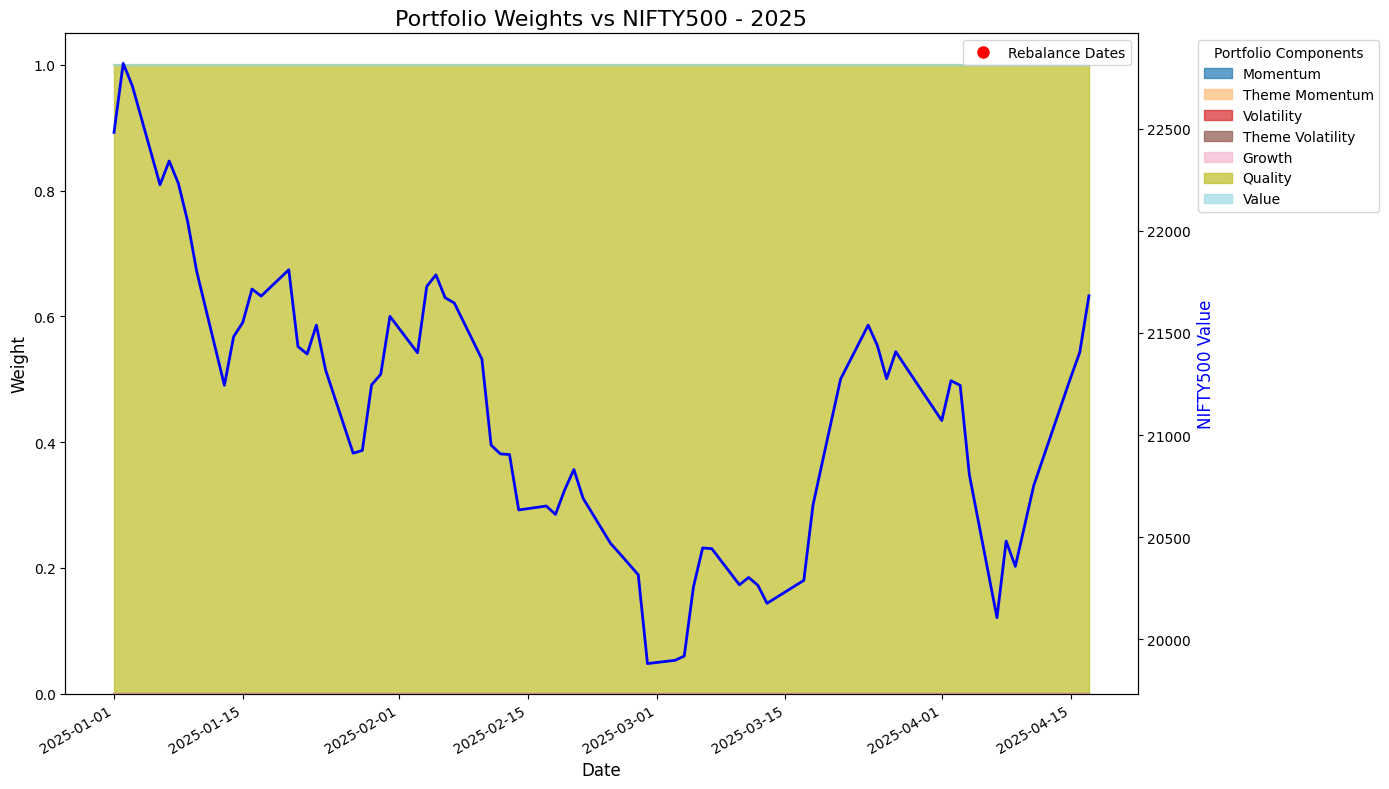

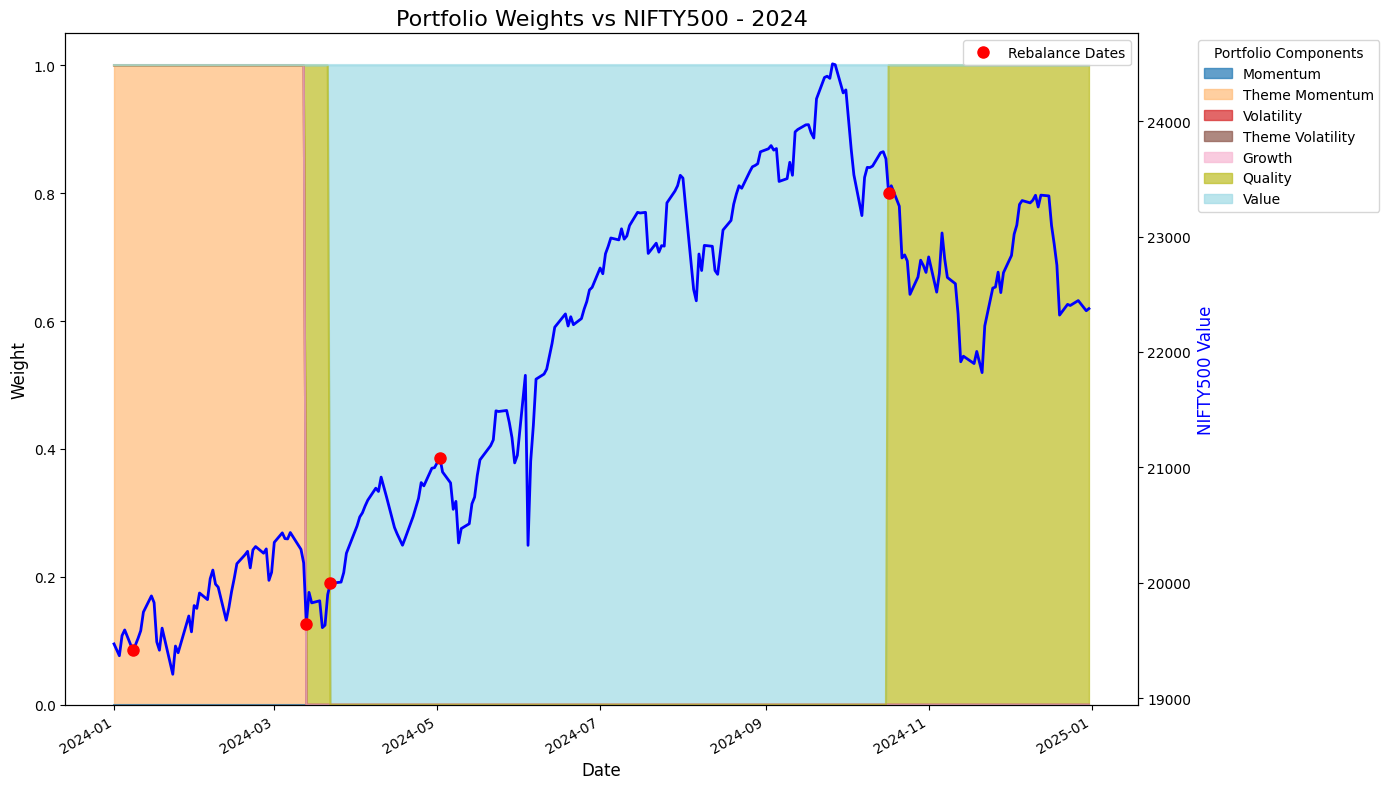

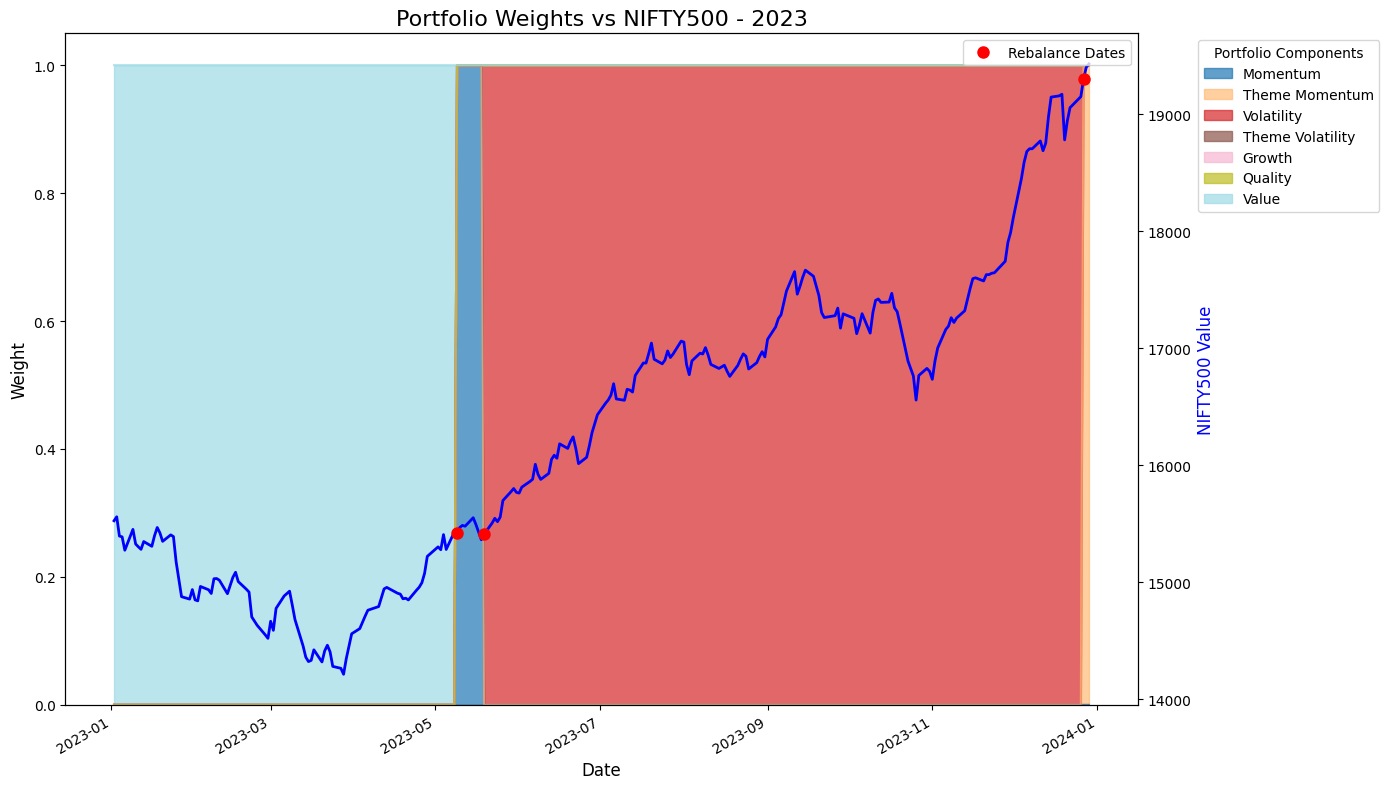

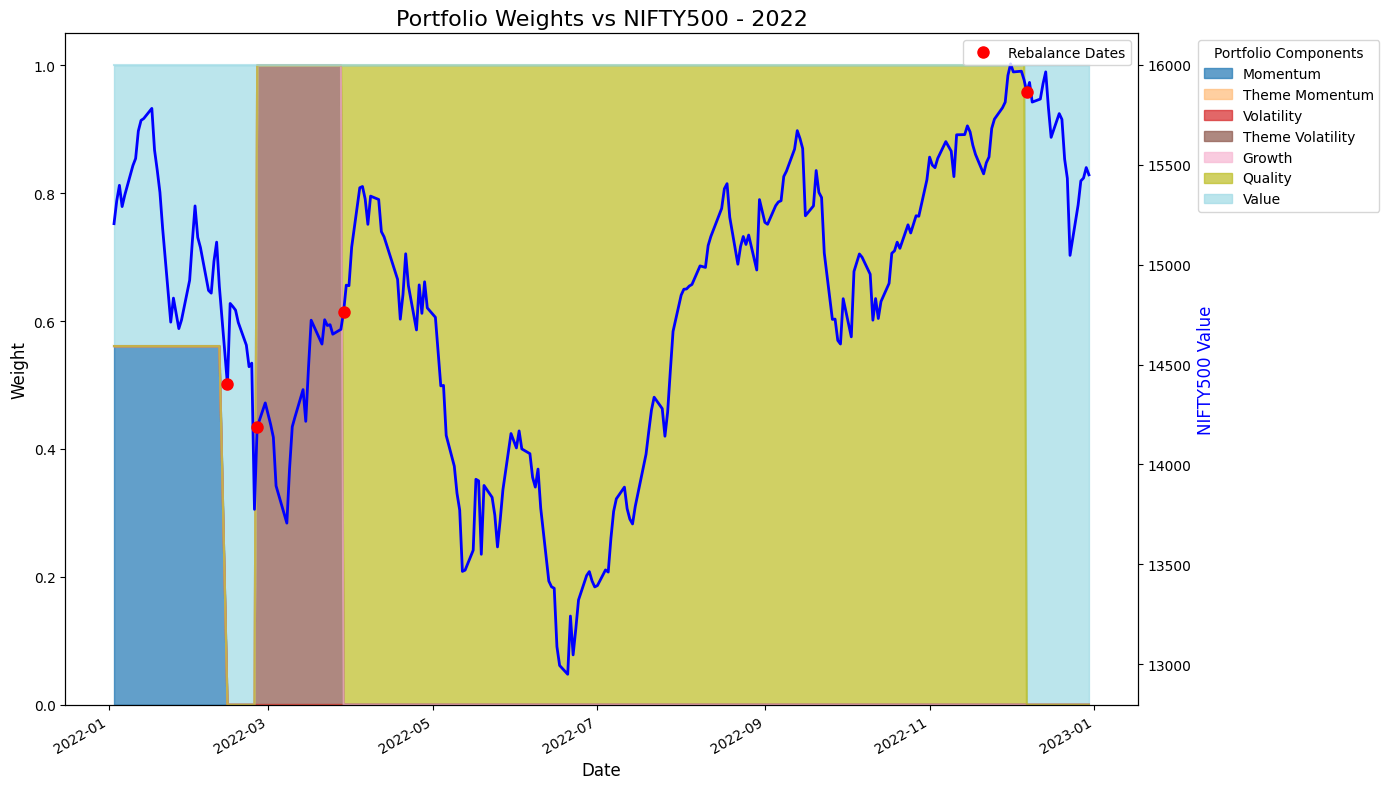

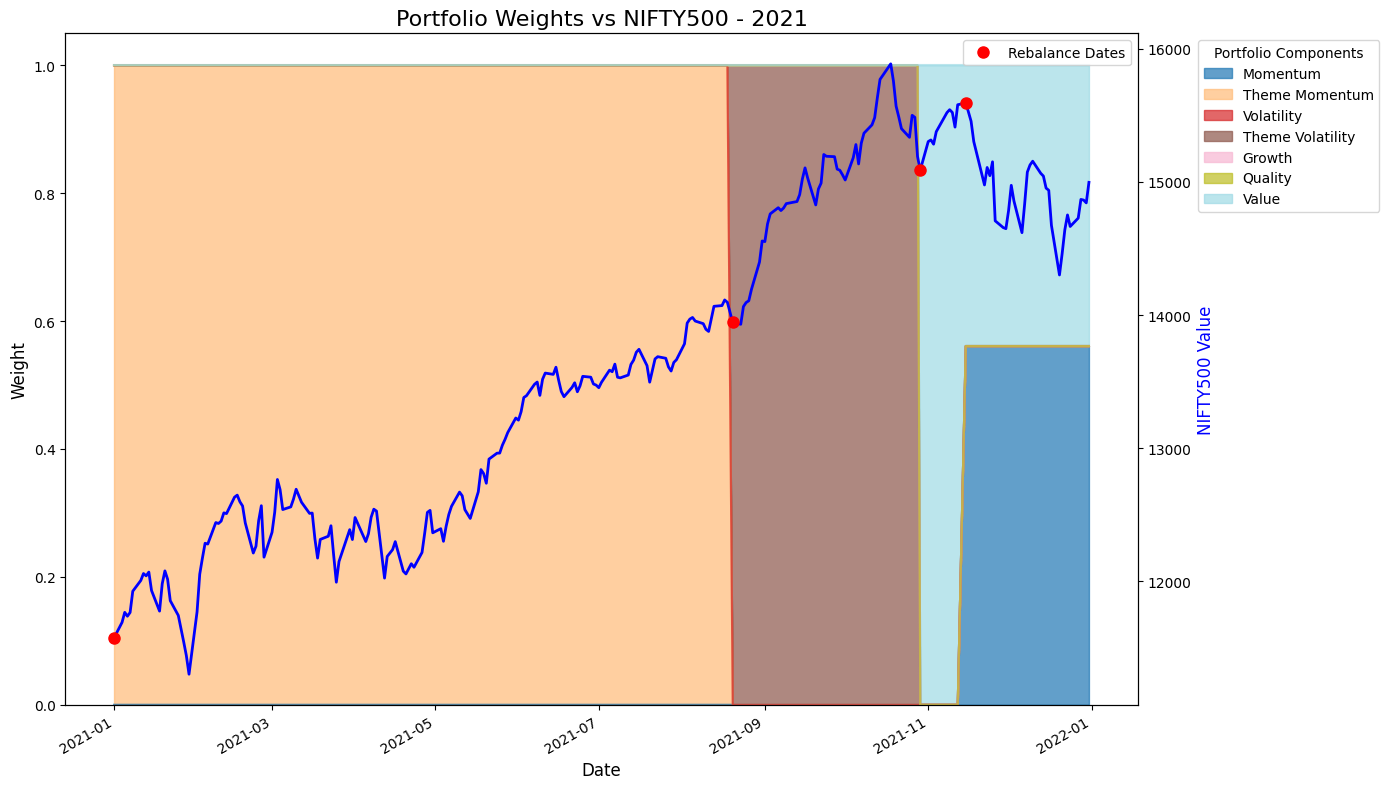

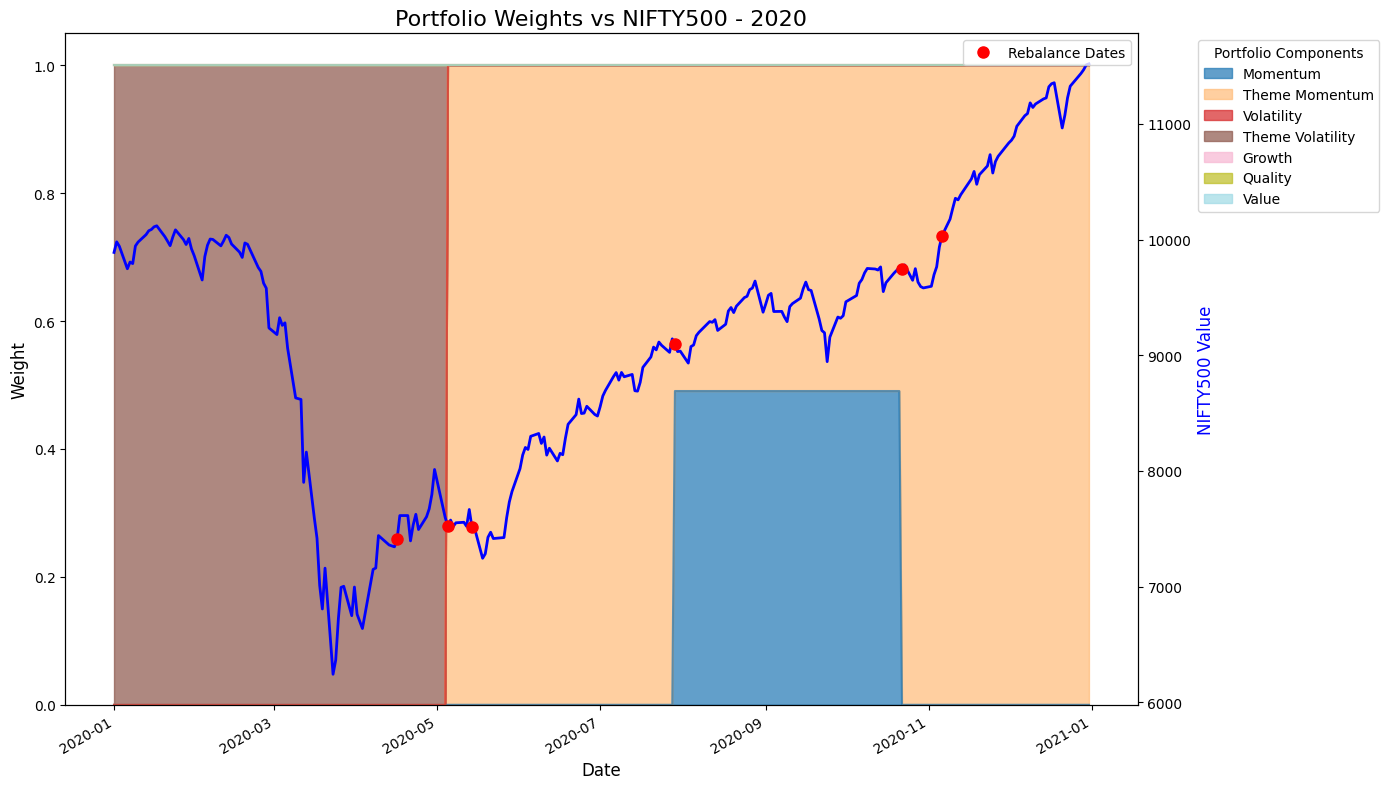

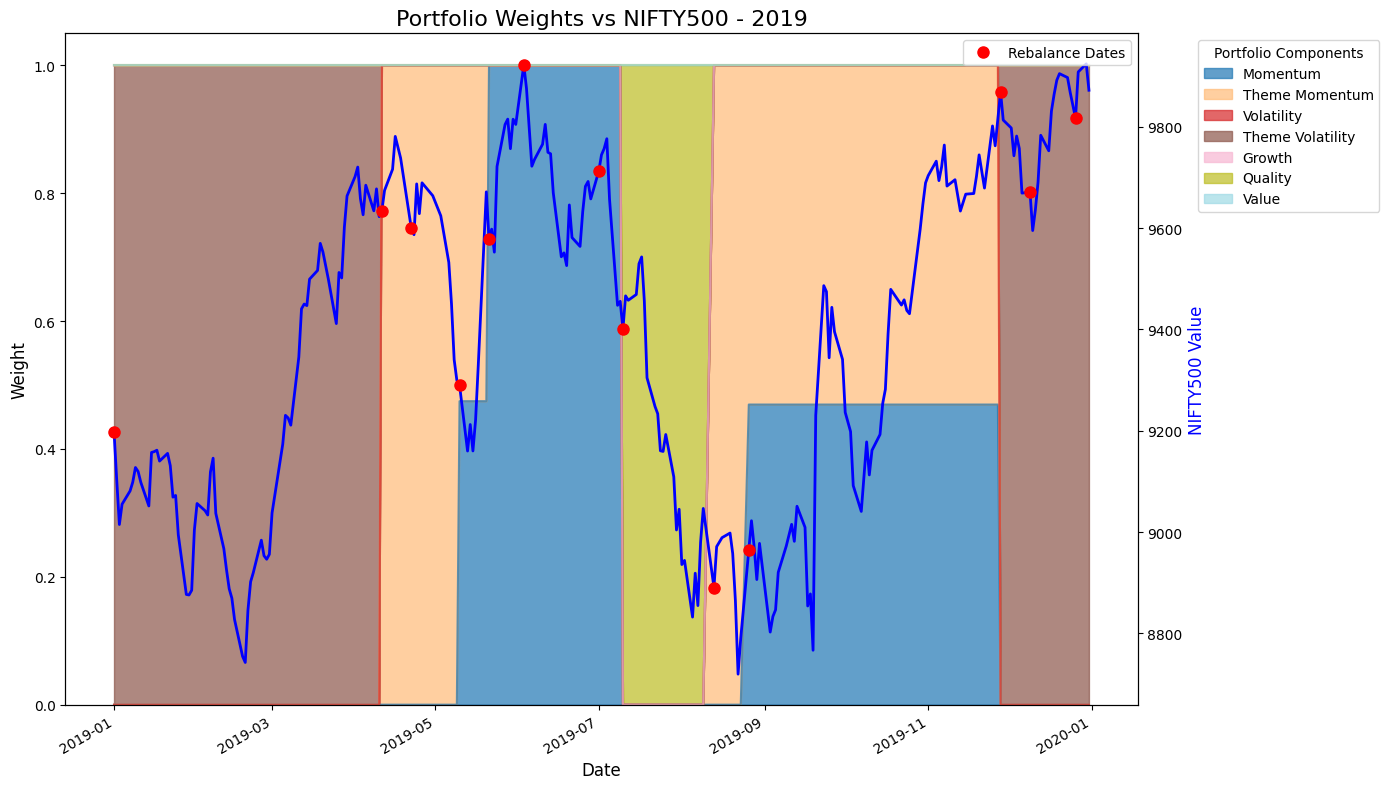

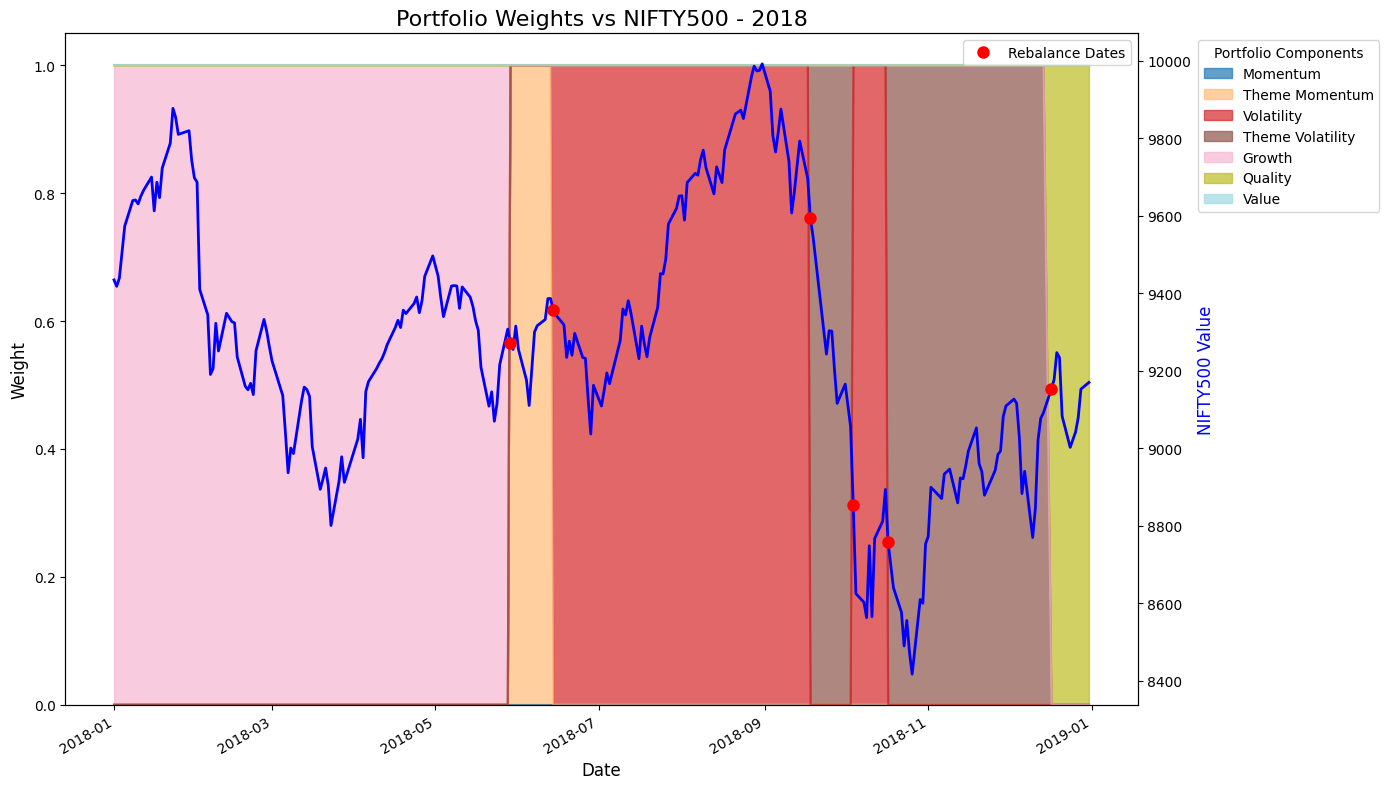

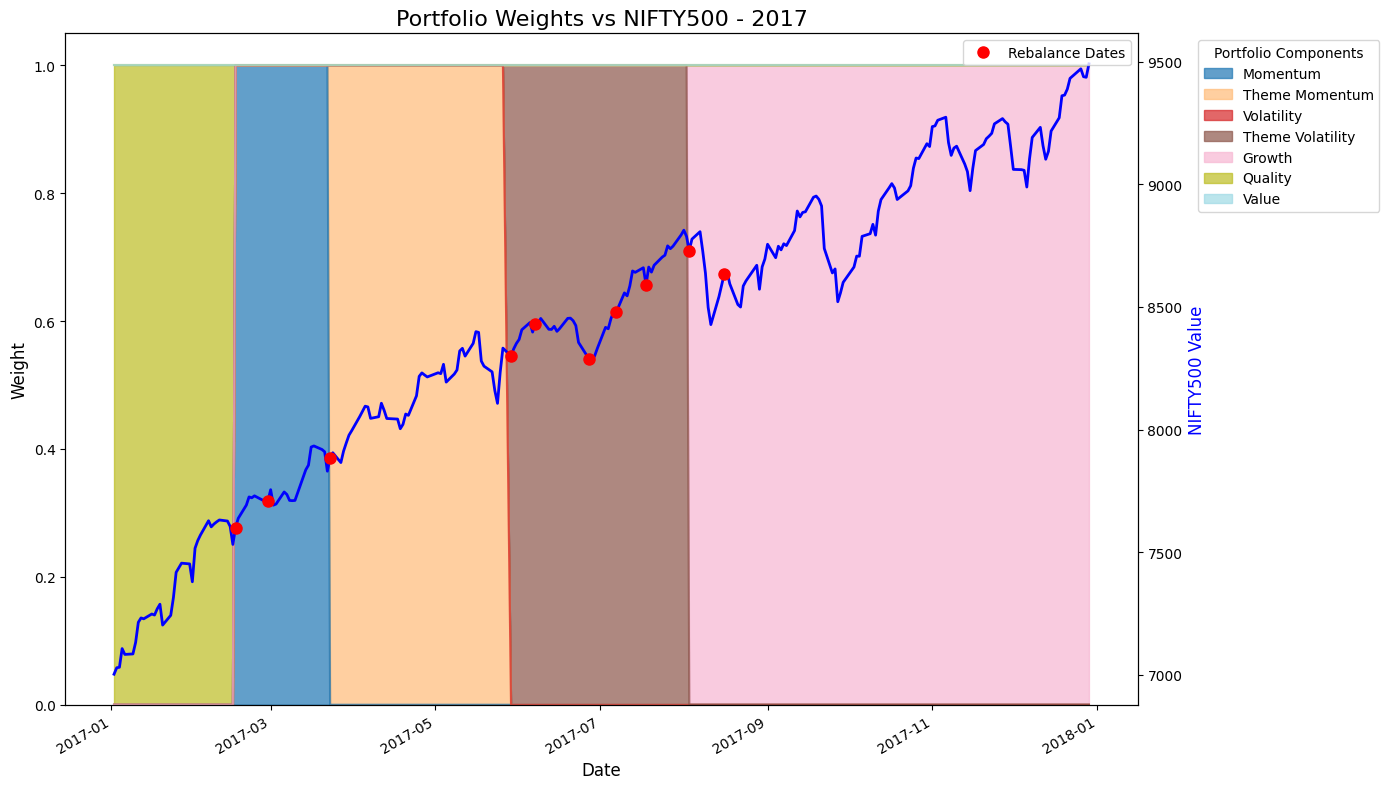

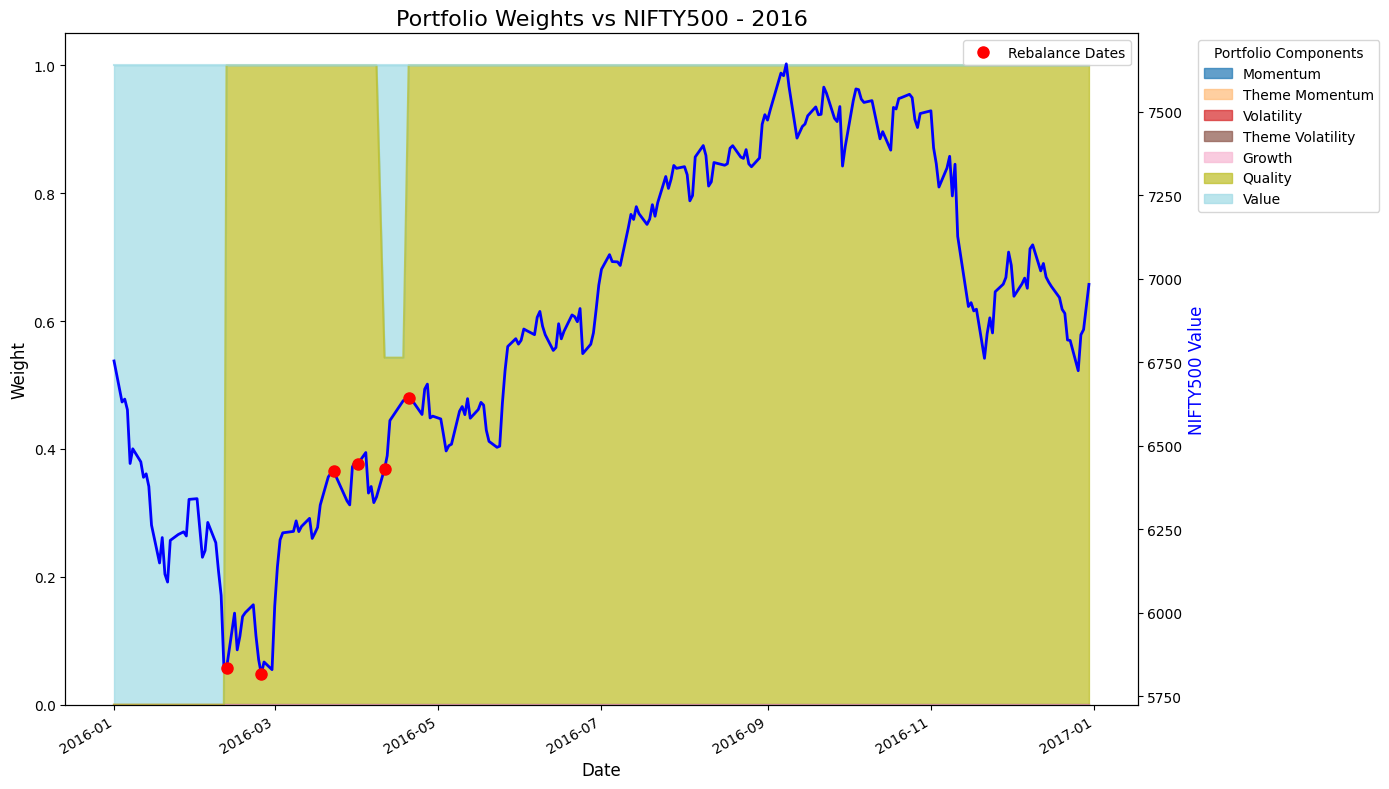

In [70]:
# Ensure 'Date' in df is datetime
# df['Date'] = pd.to_datetime(df['Date'])

# Set index to Date for easier handling
# df = df.set_index('Date')

# Create an empty DataFrame to store filled weights
filled_weights = pd.DataFrame(index=df.index, columns=df.columns)

# Your list of rebalance dates - ensure it's datetime
real_rebalance_dates = pd.to_datetime(real_rebalance_dates)
real_rebalance_dates = real_rebalance_dates.sort_values().reset_index(drop=True)

# Loop through each rebalance date and fill weights till next
for i in range(len(real_rebalance_dates) - 1):
    start = real_rebalance_dates[i]
    end = real_rebalance_dates[i + 1]
    if start in df.index:
        filled_weights.loc[start:end] = df.loc[start].values

# Forward-fill the last rebalance date's weights to the end
last_date = real_rebalance_dates.iloc[-1]
if last_date in df.index:
    filled_weights.loc[last_date:] = df.loc[last_date].values

# Reset index if you need the Date column back
filled_weights = filled_weights.reset_index()
# Make sure Date column is datetime
filled_weights['Date'] = pd.to_datetime(filled_weights['Date'])

# Now load the benchmark data
df1 = pd.read_excel('latest size data.xlsx')
df1 = df1[['Date', 'NIFTY500']]
df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')
df1['Date'] = df1['Date'].dt.strftime('%Y-%m-%d')
df1['Date'] = pd.to_datetime(df1['Date'])

# Merge and set Date as index
filled_weights = pd.merge(filled_weights, df1, on='Date')
filled_weights = filled_weights.dropna()
filled_weights = filled_weights.set_index('Date')

# Separate NIFTY500 from weights
nifty_data = filled_weights['NIFTY500'].copy()
weight_columns = [col for col in filled_weights.columns if col != 'NIFTY500']
weights_only = filled_weights[weight_columns]

# Get last date and calculate the 5 years before
end_year = filled_weights.index.max().year
years = list(range(end_year, end_year - 10, -1))  # Last 5 years

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

for year in years:
    yearly_data = weights_only[weights_only.index.year == year]
    yearly_nifty = nifty_data[nifty_data.index.year == year]
    
    if yearly_data.empty:
        continue  # Skip if no data

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot stacked area chart for weights
    yearly_data.plot.area(ax=ax1, stacked=True, cmap='tab20', alpha=0.7)
    ax1.set_title(f"Portfolio Weights vs NIFTY500 - {year}", fontsize=16)
    ax1.set_ylabel("Weight", fontsize=12)
    ax1.set_xlabel("Date", fontsize=12)
    
    # Create second y-axis for NIFTY500
    ax2 = ax1.twinx()
    ax2.plot(yearly_nifty.index, yearly_nifty.values, 'b-', linewidth=2, label='NIFTY500')
    ax2.set_ylabel('NIFTY500 Value', color='b', fontsize=12)
    
    # Add rebalance dates as red dots
    # First filter rebalance dates for the current year
    year_rebal_dates = [date for date in real_rebalance_dates if date.year == year]
    
    for rebal_date in year_rebal_dates:
        if rebal_date in yearly_nifty.index:
            nifty_val = yearly_nifty.loc[rebal_date]
            ax2.plot(rebal_date, nifty_val, 'ro', markersize=8, label='_nolegend_')
    
    # Add red dot to legend manually
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', marker='o', linestyle='None', markersize=8)]
    ax2.legend(custom_lines, ['Rebalance Dates'], loc='upper right')
    
    # Adjust primary axis legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Portfolio Components")
    
    plt.tight_layout()
    plt.show()

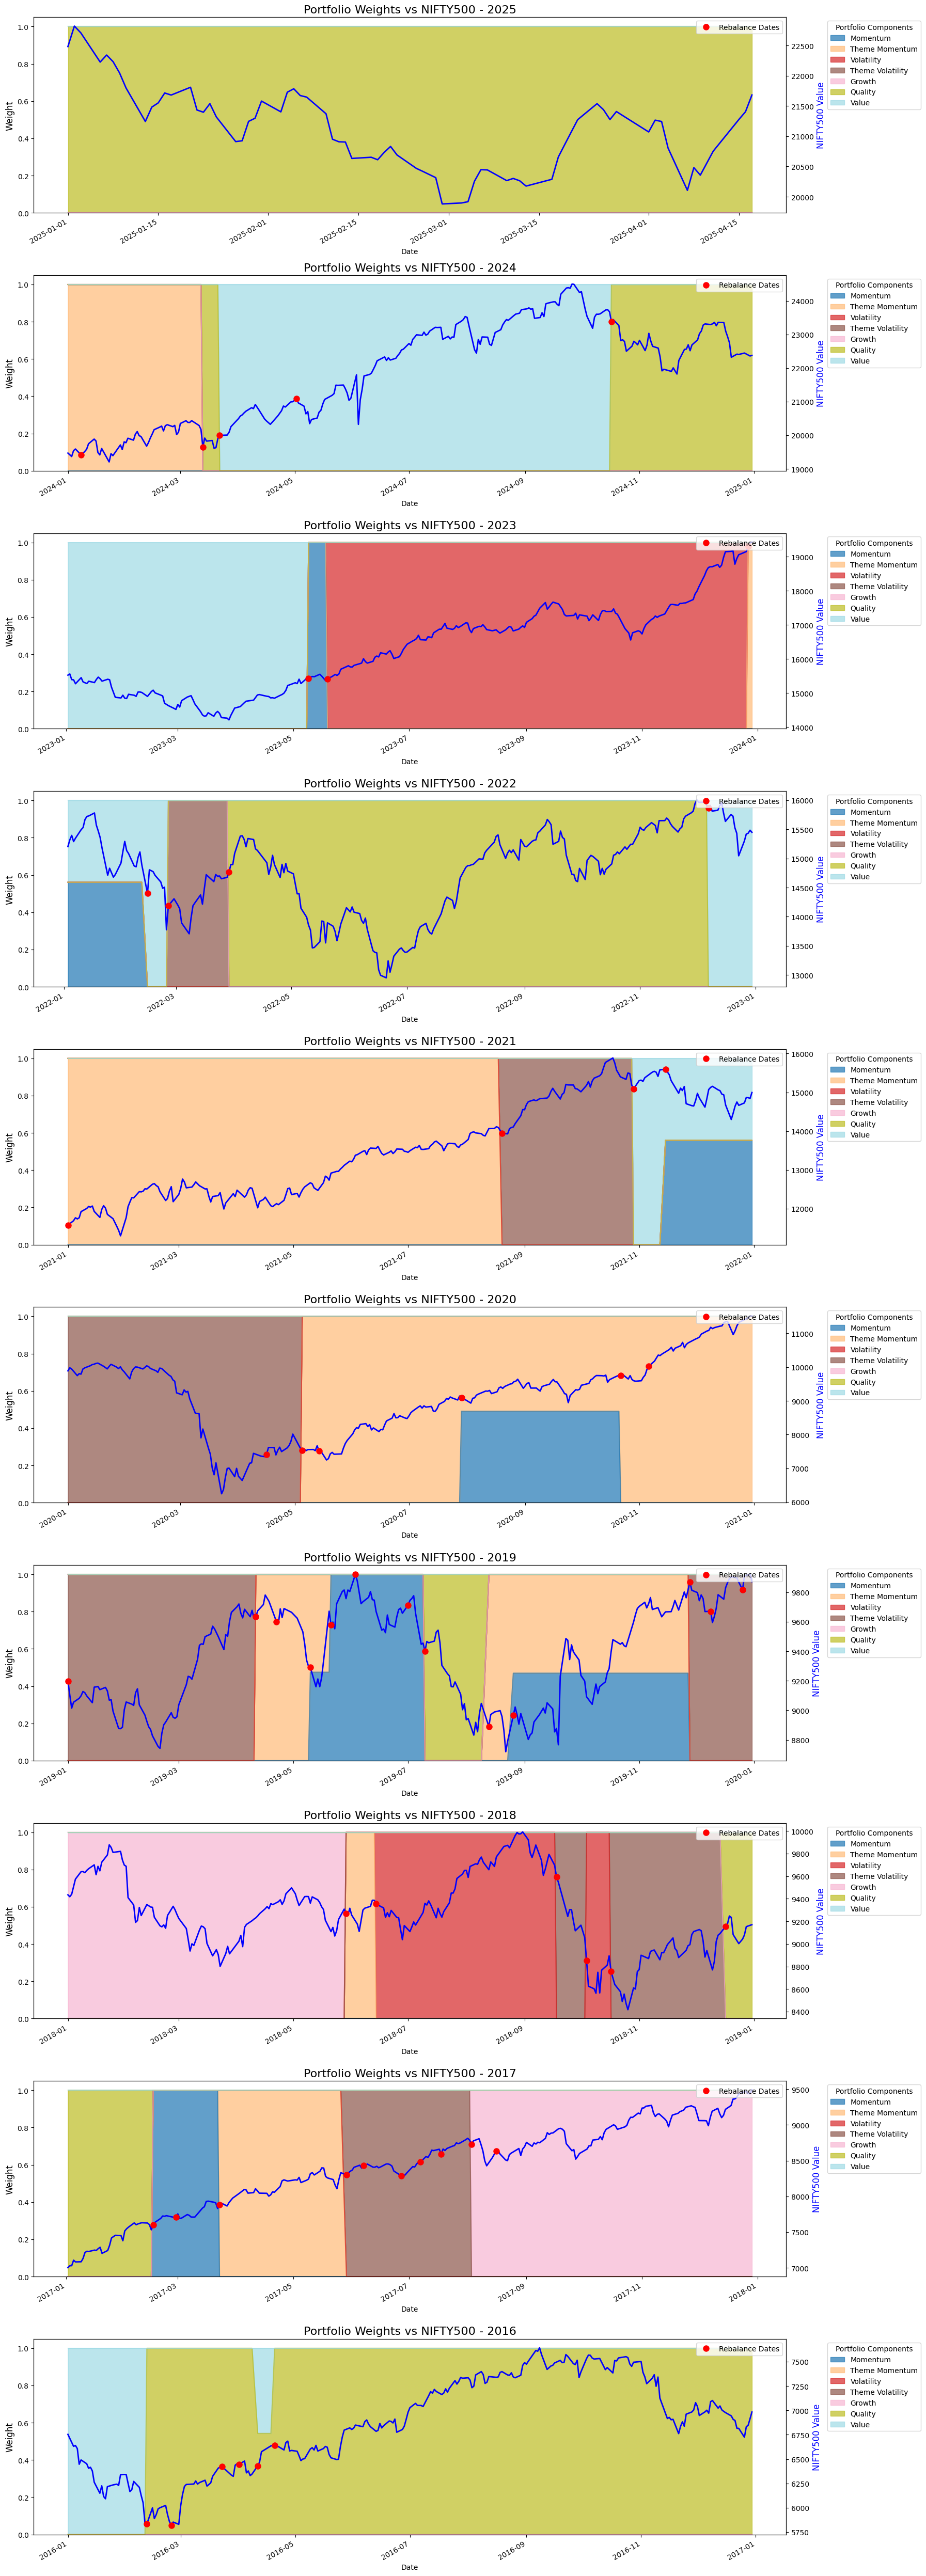

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.lines import Line2D

# Create figure with multiple subplots
n_years = len(years)
fig, axes = plt.subplots(n_years, 1, figsize=(18, 5 * n_years), sharex=False)

# If only one year, axes is not a list — make it a list
if n_years == 1:
    axes = [axes]

for idx, year in enumerate(years):
    yearly_data = weights_only[weights_only.index.year == year]
    yearly_nifty = nifty_data[nifty_data.index.year == year]
    
    if yearly_data.empty:
        continue  # Skip if no data
    
    ax1 = axes[idx]
    
    # Plot stacked area chart for weights
    yearly_data.plot.area(ax=ax1, stacked=True, cmap='tab20', alpha=0.7)
    ax1.set_ylabel("Weight", fontsize=12)
    ax1.set_title(f"Portfolio Weights vs NIFTY500 - {year}", fontsize=16)

    # Create second y-axis
    ax2 = ax1.twinx()
    ax2.plot(yearly_nifty.index, yearly_nifty.values, 'b-', linewidth=2, label='NIFTY500')
    ax2.set_ylabel('NIFTY500 Value', color='b', fontsize=12)

    # Add rebalance dates as red dots
    year_rebal_dates = [date for date in real_rebalance_dates if date.year == year]
    
    for rebal_date in year_rebal_dates:
        if rebal_date in yearly_nifty.index:
            nifty_val = yearly_nifty.loc[rebal_date]
            ax2.plot(rebal_date, nifty_val, 'ro', markersize=8, label='_nolegend_')
    
    # Adjust primary axis legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Portfolio Components")
    
    # Add red dot manually to secondary axis legend
    custom_lines = [Line2D([0], [0], color='r', marker='o', linestyle='None', markersize=8)]
    ax2.legend(custom_lines, ['Rebalance Dates'], loc='upper right')

plt.tight_layout()
plt.show()
